# Chapter 7: k Means

### Practical Applications of k-Means Clustering

Before we dive into the technical implementation, let's explore some real-world applications where k-means clustering makes a significant impact:

1. **Customer Segmentation**
   - Group customers based on purchasing behavior
   - Identify similar shopping patterns
   - Customize marketing strategies for each segment

2. **Image Compression**
   - Reduce image colors to k dominant colors
   - Each pixel gets assigned to nearest color cluster
   - Useful for web graphics and mobile applications

3. **Document Classification**
   - Group similar documents automatically
   - Identify topics in large text collections
   - Organize news articles by theme

4. **Anomaly Detection**
   - Identify unusual patterns in data
   - Find fraudulent transactions
   - Detect network intrusions

Throughout this notebook, we'll implement k-means clustering on a digits dataset, but remember that the same principles apply to these real-world scenarios!

In [66]:
low_memory=False
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set()
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from scipy.stats import mode

## 7.1 Introduction & Motivation

Welcome to the Unsupervised Learning section of this course! If you're reading this, you've successfully reached the midpoint of Data Science Fundamentals. Congratulations!

Now, let's dive into our first unsupervised learning problem: **clustering**. Until now, we've worked with datasets that had both dependent and independent variables. We tried to build models that could predict values of the dependent variable based on the independent variables. This was simplified because we always had the target values in our training set.

In unsupervised learning, we don't have this luxury. We only have the independent variables and must find patterns within them. Specifically, we'll focus on identifying clusters in the data.

As they say, a picture is worth a thousand words:

In [67]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In this visualization, we can clearly see a pattern: there are 4 distinct clusters of points. The goal of cluster analysis is to identify these natural groupings and use the model to predict which cluster new observations belong to.

To put this in perspective with supervised learning, each cluster might correspond to a specific value of the dependent variable in classification tasks.

## 7.2 Problem Setting

For this chapter, we'll revisit a modified version of the problem we explored in the classification chapters. We'll work with the handwritten digits dataset again, but with a key difference: this time, we won't use any of the provided labels!

In [68]:
digits = load_digits()
digits.data.shape

(1797, 64)

As we can see, our dataset contains 1,797 observations, each with 64 variables. Our goal is to group these observations into classes without using their labels. We hope that these automatically discovered classes will correspond to the actual digit labels.

While we're artificially removing the labels here to simulate unsupervised learning, this scenario is very common in real-world applications where true labels are not available.

## 7.3 Model

### 7.3.1 Model

The k-Means algorithm requires one hyperparameter, k, which represents the number of clusters we want to identify. The algorithm works as follows:

1. Choose k random points in our feature space as initial cluster centers
2. Assign each observation to the nearest cluster center
3. Recalculate cluster centers as the mean of all points assigned to each cluster
4. Repeat steps 2 and 3 until the cluster assignments no longer change

More formally, the algorithm follows an Expectation-Maximization approach:

1. Initialize random cluster centers
2. Repeat until convergence:
   - E-Step: Assign points to the nearest cluster center
   - M-Step: Update cluster centers to the mean of assigned points

This process is visualized in the diagram below:

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)

### Demystifying the Math Behind k-Means

While the algorithm might seem simple, there's some interesting mathematics behind it. Let's break it down:

1. **Distance Calculation**
   - We use Euclidean distance: $d = \sqrt{\sum_{i=1}^n (p_i - q_i)^2}$
   - For two points p and q in n-dimensional space
   - This is just the geometric distance between points

2. **Centroid Calculation**
   - For each cluster j: $\mu_j = \frac{1}{|C_j|} \sum_{i \in C_j} x_i$
   - Where $C_j$ is the set of points in cluster j
   - $|C_j|$ is the number of points in cluster j
   - $x_i$ are the individual data points

3. **Objective Function**
   - We minimize: $J = \sum_{j=1}^k \sum_{i \in C_j} ||x_i - \mu_j||^2$
   - This is called the "inertia" or "within-cluster sum of squares"
   - Lower values mean better-defined clusters

Don't worry if the math looks intimidating - the key intuition is that we're:
1. Finding the nearest center for each point
2. Moving centers to the middle of their assigned points
3. Repeating until things stabilize

Now, let's see how this works in practice!

### 7.3.2 Model Estimation

Luckily, SKLearn makes it really easy for us to execute this algorithm:

In [69]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


(10, 64)

Our analysis produces 10 cluster centers, each represented by 64 variables. These centers define the characteristic points of each cluster. When a new observation appears, it will be assigned to the cluster with the nearest center. Let's visualize these cluster centers:

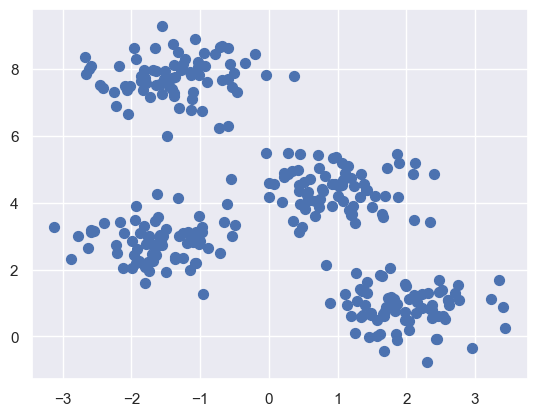

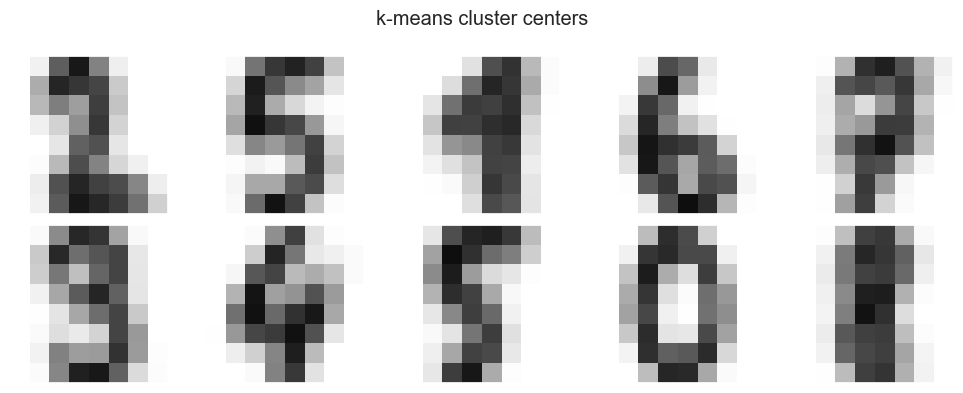

In [70]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary, vmin=0, vmax=16)
    axi.set_xticks([])
    axi.set_yticks([])
fig.suptitle('k-means cluster centers')
plt.tight_layout()
plt.show()

Remarkably, even without using the labels, k-means has discovered clusters whose centers resemble recognizable digits. Most digits are clearly identifiable, though there appears to be some ambiguity between the digits 1 and 8.

To evaluate how well our clustering performs, let's compare it with the actual digit labels. We'll reintroduce the true labels to assess our model's accuracy:

### Understanding Model Performance

Let's dive deeper into how we evaluate our clustering results. In supervised learning, we had clear metrics like accuracy or MSE. In clustering, it's more complex because we don't have true labels (in real applications). Here's what we're doing:

1. **Label Mapping**
   - For each cluster, we find the most common true digit
   - This becomes that cluster's "predicted" label
   - Example: if cluster 3 mostly contains 7s, we map cluster 3 → 7

2. **Why 74% Accuracy is Actually Good**
   - Remember, the model had NO knowledge of actual digits
   - It only saw pixel patterns
   - 74% accuracy from pure pattern recognition is impressive!

3. **Types of Errors**
   - Within-class variation: Same digit written differently
   - Between-class similarity: Different digits looking similar
   - These are challenges even humans face!

In [71]:
labels = np.zeros_like(clusters)
for i in range(10):
    ## only select the positions where the current number is i
    mask = (clusters == i)
    ## figure out which number this most likely represents and map it
    ## mode picks the value that occurs the most
    labels[mask] = mode(digits.target[mask])[0]

Let's start by calculating the overall accuracy score:

In [72]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7440178074568725

These results are remarkable! Our model has correctly identified 74% of all digits purely based on the underlying structure, without any knowledge of the true labels. To better understand where the model makes mistakes, let's examine the confusion matrix:

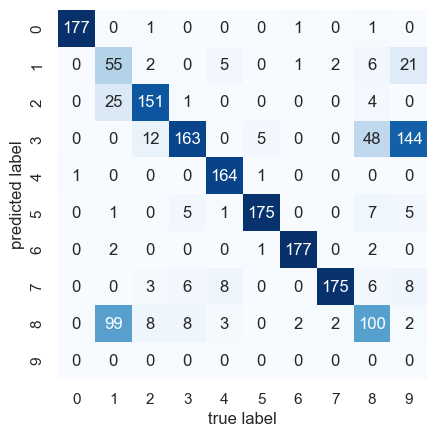

In [73]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=digits.target_names, yticklabels=digits.target_names, cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

The confusion matrix reveals the following common misclassifications:

* The digit 1 is sometimes confused with 8
* The digit 5 is sometimes confused with 3
* The digit 8 is sometimes confused with 3
* The digit 8 is sometimes confused with 3 and 21

##### Question 1: Why does the model sometimes predict 8 instead of 1? Can you explain this phenomenon?

Since our model has no access to the true labels, it relies solely on the pixel patterns in the images. The data patterns representing the digit 8 can be quite similar to those representing 1, especially in certain handwriting styles. Without label information to guide the distinction between these digits, the model sometimes groups them together based on their visual similarities alone.

### 7.4 Model Evaluation

The k-means algorithm requires us to specify the number of clusters (k) as a hyperparameter. In our digits example, it's obvious that we should look for 10 clusters (one for each digit 0-9). Even without access to the labels, we would know to expect 10 distinct groups, or perhaps 11 if there were non-digit images in the dataset.

However, in real-world applications, we often don't have this prior knowledge. Consider Netflix's challenge of categorizing movies by genre: How many distinct genres exist? Is there a clear boundary between action and crime movies? In such cases, we have no predetermined number of clusters, yet we still need to choose an optimal value for k.

For k-means clustering, we typically address this by fitting the model with different k values and comparing their performance.

### Limitations and Considerations of k-Means

Before we move on to choosing k, it's important to understand what k-means can and cannot do:

1. **Assumptions About Data**
   - Clusters are roughly spherical
   - Clusters are of similar size
   - Data points belong to exactly one cluster

2. **Potential Challenges**
   - Sensitive to initial center positions
   - May converge to local optima
   - Struggles with:
     * Elongated clusters
     * Irregular shapes
     * Clusters of very different sizes

3. **When to Use k-Means**
   ✅ Well-separated groups
   ✅ Similar-sized clusters
   ✅ Roughly spherical clusters
   ❌ Complex shapes
   ❌ Highly uneven cluster sizes
   ❌ Hierarchical structure needed

This understanding helps us make informed decisions about when to use k-means and what alternatives to consider!

While we previously compared our clusters to the true labels, this isn't usually possible in real applications. Instead, we can evaluate cluster quality by measuring the variance (or distance) between clusters. Larger inter-cluster distances typically indicate more distinct and well-defined clusters.

In [74]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(digits.data)
    distortions.append(kmeanModel.inertia_)

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

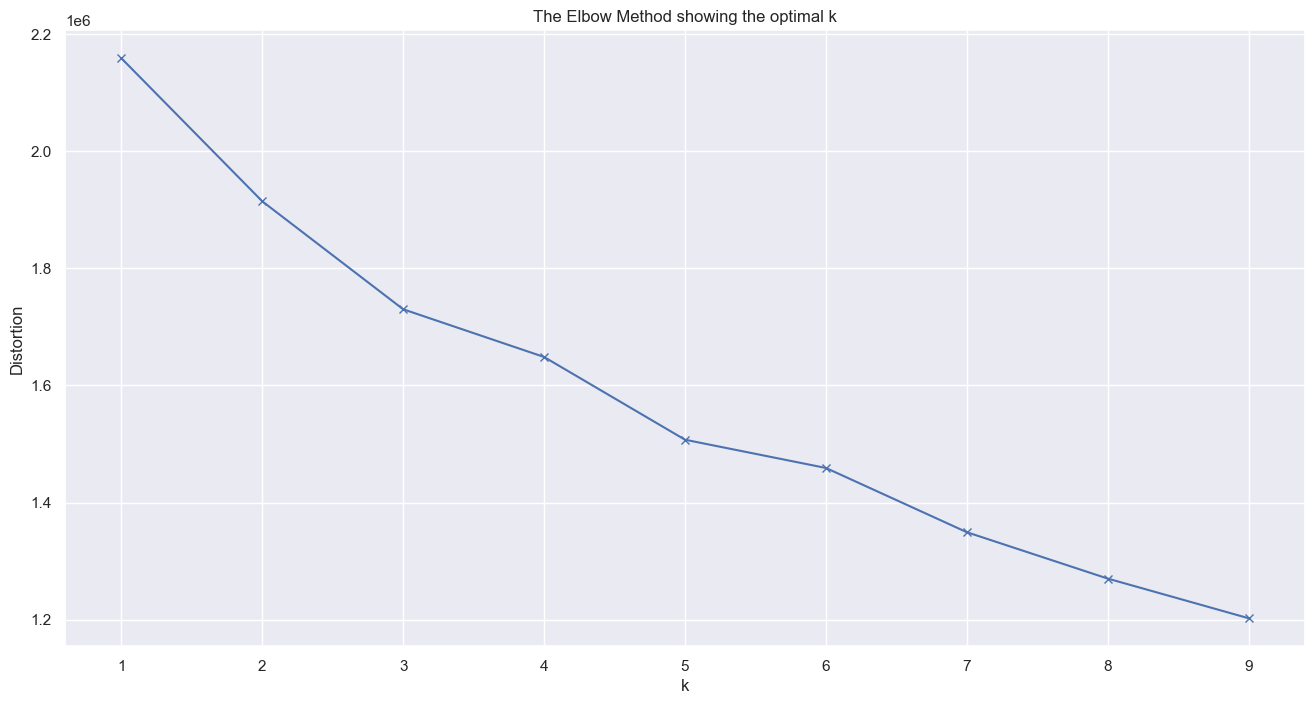

In [75]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

This visualization technique is known as the *Elbow Method*. The graph typically shows a distinct bend (like an elbow) at the optimal number of clusters. 

##### Question 2: Why don't we see a clear elbow in this graph? How can we fix the code to better visualize this pattern?

We know the optimal value should be 10 (appearing at position 9 in the graph). However, our current graph only extends to k=9, showing just half of the elbow pattern. To properly visualize the full elbow curve, we need to extend our analysis to include more k values.

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

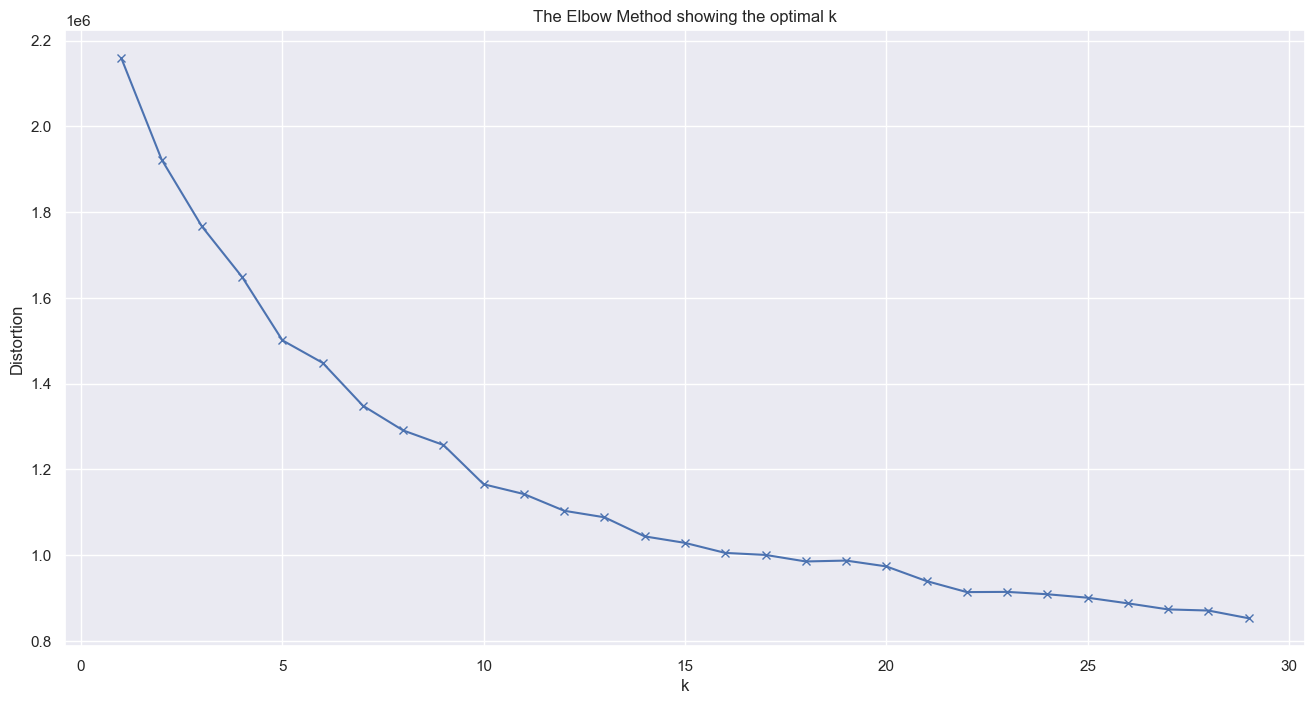

In [76]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(digits.data)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### Question 3: How well does the elbow method's result align with our prior knowledge about the optimal number of clusters? Explain your reasoning.

The expanded visualization confirms our expectation that k=10 is indeed optimal, as it appears at the bend of the elbow curve. While we knew this from our understanding of the digits dataset, it's valuable to see that the elbow method independently suggests the same conclusion through pure data analysis.

## 7.4 Questions

##### Question 1: See section 7.3.3 (Confusion between digits 8 and 1)
##### Question 2: See section 7.3.4 (Elbow method visualization)
##### Question 3: See section 7.4 (Optimal number of clusters)
##### Question 4: Evaluate the k-means model's performance on unseen data by splitting the dataset into training and test sets, similar to our previous approaches. How well does the model generalize to new data?

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


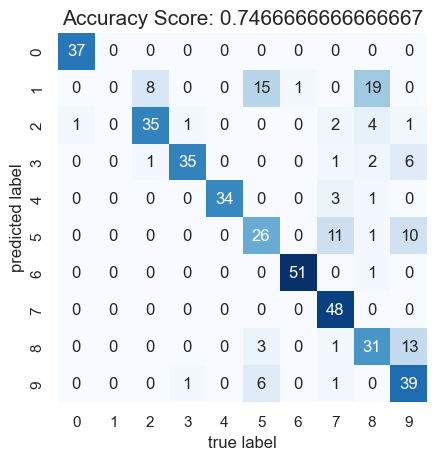

In [77]:
digits = load_digits()
digits.data.shape

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X_test)
kmeans.cluster_centers_.shape

labels = np.zeros_like(clusters)
for i in range(10):
    ## only select the positions where the current number is i
    mask = (clusters == i)
    ## figure out which number this most likely represents and map it
    ## mode picks the value that occurs the most
    labels[mask] = mode(y_test[mask])[0]

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

score = accuracy_score(labels, y_test)
cm = confusion_matrix(y_test, labels)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, xticklabels=digits.target_names, yticklabels=digits.target_names, cmap="Blues")
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(all_sample_title, size = 15)
plt.show()

Interestingly, while our accuracy has changed slightly, it remains remarkably similar to our previous results. This behavior differs from what we typically expect in supervised learning, where reduced training data usually leads to lower performance. In clustering, while dataset size still affects the final model, its impact is less pronounced than in classification or regression tasks. This stability suggests that k-means can effectively capture the underlying structure of the data even with fewer samples.

### Key Takeaways and Best Practices

As we conclude this exploration of k-means clustering, let's summarize the key learnings and best practices:

1. **Algorithm Selection**
   - Use k-means when:
     * You know approximately how many clusters to expect
     * Your data forms roughly spherical clusters
     * You need a simple, fast clustering solution

2. **Preprocessing Steps**
   - Always scale your features (our digit data was already 0-255 scaled)
   - Remove outliers if possible
   - Consider dimensionality reduction for high-dimensional data

3. **Model Validation**
   - Use multiple random initializations (n_init parameter)
   - Try different values of k
   - When possible, validate against known labels
   - Consider silhouette scores for unlabeled data

4. **Common Pitfalls to Avoid**
   - Don't assume all data is clusterable
   - Don't rely solely on the elbow method
   - Don't forget to scale features
   - Don't ignore domain knowledge when choosing k

Remember: k-means is just one tool in the clustering toolbox. For complex real-world problems, you might need to explore alternatives like DBSCAN, hierarchical clustering, or Gaussian mixture models.